In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from tueplots import figsizes, fontsizes, fonts, bundles, axes

from histaug.analysis.bootstrap import compare_bootstraps
from histaug.analysis.collect_results import load_results
from histaug.utils.display import RENAME_MODELS, RENAME_FEATURE_EXTRACTORS, FEATURE_EXTRACTOR_GROUPS
from histaug.utils import rc_context, savefig

In [4]:
# MAGNIFICATION = "high"
MAGNIFICATION = "low"

augmentation_groups_to_compare = [
    "Macenko_slidewise",
    "Macenko_patchwise",
    # "simple_rotate",
    # "all",
]
if MAGNIFICATION == "high":
    augmentation_groups_to_compare = ["Macenko_patchwise"]

dfs = []
results = load_results()
for aug in augmentation_groups_to_compare:
    df = compare_bootstraps(results, "augmentations", "none", aug)
    df["augmentation"] = aug
    dfs.append(df)

df = (
    pd.concat(dfs)
    .reset_index()
    .set_index(["augmentation", "model", "feature_extractor"])
    .query("magnification == @MAGNIFICATION")
    .drop(columns=["target", "magnification"])
)
df

2024-02-01 21:00:06.648 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading results from cache
2024-02-01 21:00:06.784 | DEBUG    | histaug.utils.caching:wrapper:20 - Loading bootstrapped_augmentations_none_vs_Macenko_slidewise_2110f8f095360e1c4c5466e8ecafe2c0 from cache
magnification=low feature_extractor=vits model=Transformer target=subtype: 100%|██████████| 372/372 [07:40<00:00,  1.24s/it]                


train_dataset  ... auroc_diff
augmentation      model        feature_extractor                     ...           
Macenko_slidewise AttentionMIL bt                     tcga_crc_BRAF  ...   0.047101
                               bt                     tcga_crc_BRAF  ...   0.105676
                               bt                     tcga_crc_BRAF  ...   0.048889
                               bt                     tcga_crc_BRAF  ...   0.079106
                               bt                     tcga_crc_BRAF  ...  -0.021120
...                                                             ...  ...        ...
Macenko_patchwise Transformer  vits               tcga_brca_subtype  ...  -0.001828
                               vits               tcga_brca_subtype  ...  -0.121570
                               vits               tcga_brca_subtype  ...  -0.015386
                               vits               tcga_brca_subtype  ...  -0.024576
                               vits               tcga_brca_subtype  ...  -0.055513

[81000 rows x 4 columns]

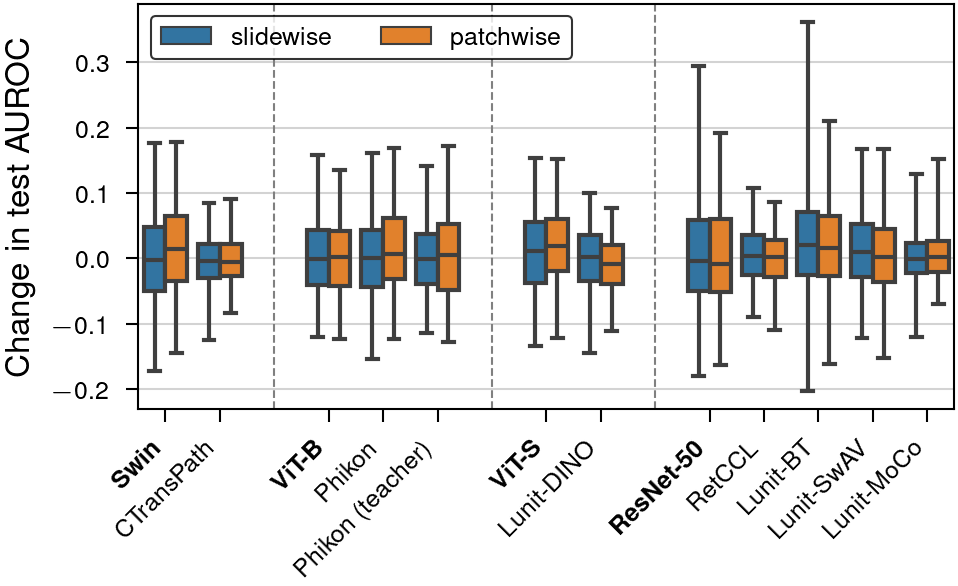

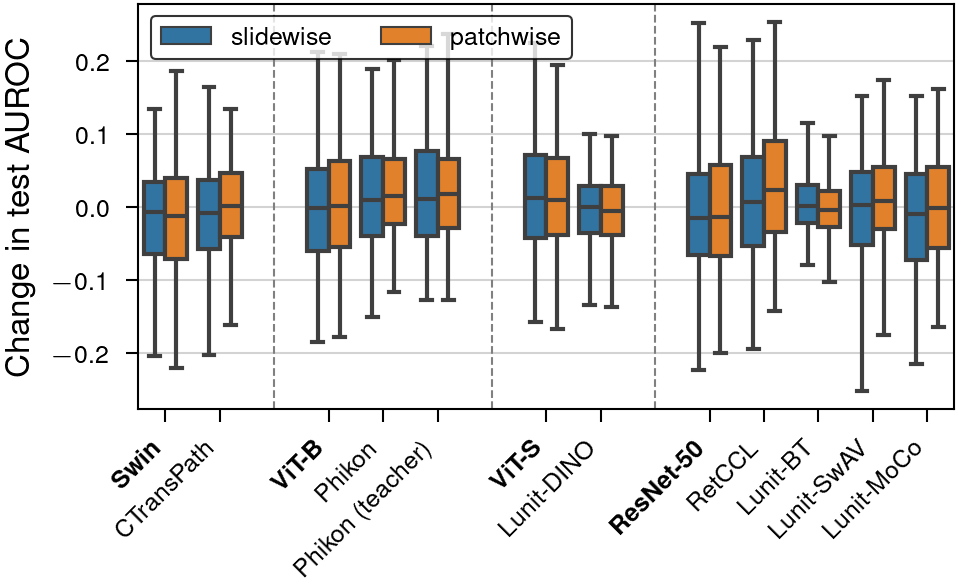

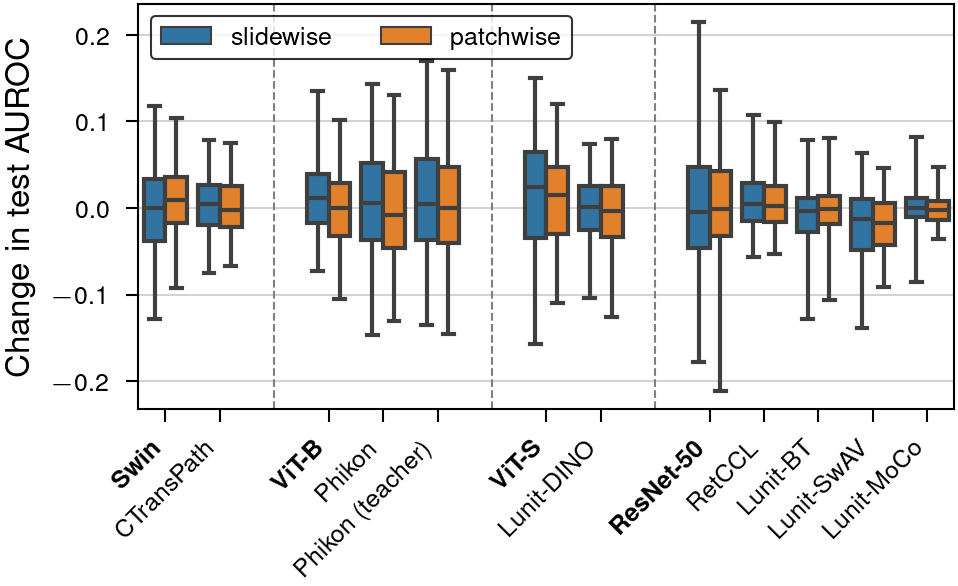

In [7]:
# sns.set_theme(style="whitegrid")
# sns.violinplot(
#     data=df.query("model == 'Transformer'"),
#     x="feature_extractor",
#     y="auroc_diff",
#     hue="method",
#     split=True,
#     fill=False,
#     # inner="quart",
#     # density_norm="width",
#     native_scale=True,
# )
# sns.violinplot(
#     data=df.query("model == 'Transformer' and method == 'slidewise'"),
#     x="feature_extractor",
#     y="auroc_diff",
#     # hue="method",
#     # split=True,
#     fill=True,
#     # inner="quart",
#     # density_norm="width",
#     native_scale=True,
# )


def format_feature_extractor(new_name: str):
    if new_name in FEATURE_EXTRACTOR_GROUPS:
        return f"\\textbf{{{new_name}}}"
    return new_name


df["Feature extractor"] = (
    df.index.get_level_values("feature_extractor").map(RENAME_FEATURE_EXTRACTORS).map(format_feature_extractor)
)
df["Augmentation"] = df.index.get_level_values("augmentation").map(
    lambda x: {
        "Macenko_slidewise": "slidewise",
        "Macenko_patchwise": "patchwise",
    }.get(x, x)
)

for model in ("AttentionMIL", "Transformer", "MeanAveragePooling") if MAGNIFICATION == "low" else ("AttentionMIL",):
    with rc_context("half"):
        plt.figure()
        # Boxplot with 95% confidence interval
        sns.boxplot(
            data=df.query("model == @model"),
            x="Feature extractor",
            y="auroc_diff",
            hue="Augmentation",
            order=[
                x
                for y in [
                    [
                        *([" " * i] if i != 0 else []),
                        *[format_feature_extractor(RENAME_FEATURE_EXTRACTORS[extractor]) for extractor in extractors],
                    ]
                    for i, extractors in enumerate(FEATURE_EXTRACTOR_GROUPS.values())
                ]
                for x in y
            ],
            # ensure 95% confidence interval is shown
            showfliers=False,
            whis=[2.5, 97.5],
            # show all data points
            # showmeans=True,
        )

        # Rotate x-axis labels
        plt.xticks(rotation=45, ha="right")
        # plt.legend(loc="lower right", ncol=2, bbox_to_anchor=(1.0, 1.05), borderaxespad=0.0)
        plt.legend(loc="upper left", ncol=2)
        plt.ylabel("Change in test AUROC")
        plt.xlabel("")

        i = 0
        xticks = []
        for group in FEATURE_EXTRACTOR_GROUPS.values():
            xticks.extend(range(i, i + len(group)))
            if i != 0:
                plt.axvline(x=i - 1, linestyle="--", color="grey", linewidth=0.5)
            i += len(group) + 1

        plt.xticks(xticks, rotation=45, ha="right")

        # light grey grid
        plt.grid(axis="y", color="lightgrey")
        plt.xlabel("")
        # plt.title("Performance with vs.\\ without stain normalisation (AttMIL)")
        savefig(f"bootstrap_augmentations_{MAGNIFICATION}_{model}_{'_'.join(augmentation_groups_to_compare)}")
        plt.show()

In [8]:
from functools import partial

d = (
    df.reset_index()
    .groupby(["augmentation", "model", "feature_extractor"])["auroc_diff"]
    .agg(["mean", partial(pd.Series.quantile, q=0.025), partial(pd.Series.quantile, q=0.975)])
)
d.columns = ["mean", "ci_lo", "ci_hi"]
d = (
    "$"
    + d["mean"].map(lambda x: f"{x:+.3f}")
    + "\\ ["
    + d["ci_lo"].map(lambda x: f"{x:.3f}")
    + ", "
    + d["ci_hi"].map(lambda x: f"{x:.3f}")
    + "]$"
)
d = d.unstack("augmentation")
d = d.reset_index()
d = d.sort_values(
    by=["model", "feature_extractor"],
    key=lambda series: series.map(
        lambda x: list(
            RENAME_FEATURE_EXTRACTORS.keys() if series.name == "feature_extractor" else RENAME_MODELS.keys()
        ).index(x)
    ),
)
d["model"] = d["model"].map(RENAME_MODELS)
d["feature_extractor"] = d["feature_extractor"].map(RENAME_FEATURE_EXTRACTORS)
d = d.set_index(["model", "feature_extractor"])
d.index.names = ["Model", "Feature extractor"]
d.columns = [{"Macenko_slidewise": "Slidewise", "Macenko_patchwise": "Patchwise"}[col] for col in d.columns]
print(d.to_latex(column_format="ll|cc", escape=False))

\begin{tabular}{ll|cc}
\toprule
 &  & Patchwise & Slidewise \\
Model & Feature extractor &  &  \\
\midrule
\multirow[t]{12}{*}{AttMIL} & Swin & $+0.014\ [-0.145, 0.179]$ & $-0.001\ [-0.173, 0.178]$ \\
 & CTransPath & $-0.002\ [-0.084, 0.092]$ & $-0.006\ [-0.127, 0.086]$ \\
 & ViT-B & $+0.001\ [-0.124, 0.139]$ & $+0.004\ [-0.121, 0.160]$ \\
 & Phikon & $+0.015\ [-0.124, 0.170]$ & $+0.000\ [-0.158, 0.162]$ \\
 & Phikon (teacher) & $+0.005\ [-0.129, 0.173]$ & $+0.001\ [-0.114, 0.142]$ \\
 & ViT-S & $+0.019\ [-0.125, 0.152]$ & $+0.011\ [-0.134, 0.155]$ \\
 & Lunit-DINO & $-0.010\ [-0.111, 0.077]$ & $-0.004\ [-0.148, 0.100]$ \\
 & ResNet-50 & $+0.003\ [-0.164, 0.193]$ & $+0.011\ [-0.181, 0.295]$ \\
 & RetCCL & $-0.002\ [-0.110, 0.087]$ & $+0.006\ [-0.089, 0.110]$ \\
 & Lunit-BT & $+0.023\ [-0.167, 0.211]$ & $+0.031\ [-0.202, 0.362]$ \\
 & Lunit-SwAV & $+0.005\ [-0.154, 0.168]$ & $+0.015\ [-0.122, 0.172]$ \\
 & Lunit-MoCo & $+0.009\ [-0.071, 0.158]$ & $+0.002\ [-0.121, 0.131]$ \\
\cline{1-4}